<a href="https://colab.research.google.com/github/gmagannaDevelop/segnet/blob/mru_tests/Comparative_MultiResUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MultiResUNet
## DCI-Net
#### Gustavo Magaña

\########################################################

In [1]:
!ls

drive  sample_data


In [2]:
!apt install jq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
jq is already the newest version (1.5+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.


In [3]:
## If changes are made to the repo, uninstall and
## a fresh pip install are required, so it seems.
#!pip uninstall segnet
!pip install git+https://github.com/gmagannaDevelop/segnet.git@mru_tests
##!pip install git+https://github.com/gmagannaDevelop/segnet.git@log_hotfix

  Cloning https://github.com/gmagannaDevelop/segnet.git (to revision mru_tests) to /tmp/pip-req-build-2_197mi1
  Running command git clone -q https://github.com/gmagannaDevelop/segnet.git /tmp/pip-req-build-2_197mi1
  Running command git checkout -b mru_tests --track origin/mru_tests
  Switched to a new branch 'mru_tests'
  Branch 'mru_tests' set up to track remote branch 'mru_tests' from 'origin'.
  Created wheel for segnet: filename=segnet-0.4-cp36-none-any.whl size=22825 sha256=bb483a8b0fd7477d8e2f677d84ad3e677aec4b72a6cde1745dff1f5cbc46fad2
  Stored in directory: /tmp/pip-ephem-wheel-cache-bvxq0t4q/wheels/f1/c1/51/0ee27f445c3a618413714a84d4f5500547456389437a85a87f
Successfully built segnet


Imports

In [32]:
### System-related
import sys
import os
import datetime 
from typing import Optional
#import importlib.util
###############################################################

### Machine learning specific
#import segmentation_models as sm
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import keras.models
###############################################################

### In-Out
from skimage import io
import glob
###############################################################

### Visualization
import seaborn as sns
###############################################################

### Numerical
import numpy as np
###############################################################

### Repo-specific (segnet)
from segnet.train import train_segnet
from segnet.models import multiresunet as mru
from segnet.models import multiresunet2 as mru2
from segnet.utils import timing
#from segnet.segnet.train.train_segnet import train_segnet
#import segnet.segnet as segnet

### Data-related
from google.colab import drive, files
drive.mount('/content/drive/')
###############################################################


### Not an import, but mandatory to be defined here :
root_dir   = "drive/My Drive/DCI-Net"
_log_file  = os.path.join(root_dir, "time_logs.jsonl")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Function definition

In [0]:
def yield_model_name(
    architecture: str = "MultiResUNet",
    date: Optional[str] = None
) -> str:
  """
    Yield a model name, to be passed to other functions.
    Said model name consisting of an architecture name, 
    the (UTCtime)
  """
  if date is None:
    date = str(datetime.datetime.utcnow()).split(".")[0]
  return f"{architecture}-({date}).h5"

def yield_mask_directory(
    architecture: str = "MultiResUNet",
    date: Optional[str] = None
) -> str:
  """
    Yield a model name, to be passed to other functions.
    Said model name consisting of an architecture name, 
    the (UTCtime)
  """
  if date is None:
    date = str(datetime.datetime.utcnow()).split(".")[0].split(" ")[0]
  return f"{architecture}-({date})"

In [35]:
yield_model_name()

'MultiResUNet-(2019-11-04 03:30:48).h5'

In [7]:
yield_mask_directory()

'MultiResUNet-(2019-11-04)'

In [8]:
!ls "drive/My Drive/DCI-Net/Masks"

Sunday3nov


In [9]:
!ls "drive/My Drive/DCI-Net/Colab_data/Dataset 2"

imgs  msks


In [0]:
# Declare the paths to use (following the Keras convention)
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit_generator
masks_path = img_path = data_path  = "drive/My Drive/DCI-Net/Colab_data/Dataset 2"

_img_path   = os.path.join(data_path, 'imgs')
_masks_path = os.path.join(data_path, 'msks')


_model_snapshots_dir = os.path.join(root_dir, "ModelSnapshots")
_model_log_path = os.path.join(
    _model_snapshots_dir, 
    yield_model_name(architecture="MultiResUNet")
)


In [37]:
print(f"{data_path}\n {masks_path}\n {img_path}\n {_img_path}\n {_masks_path}\n {_model_log_path}")

drive/My Drive/DCI-Net/Colab_data/Dataset 2
 drive/My Drive/DCI-Net/Colab_data/Dataset 2
 drive/My Drive/DCI-Net/Colab_data/Dataset 2
 drive/My Drive/DCI-Net/Colab_data/Dataset 2/imgs
 drive/My Drive/DCI-Net/Colab_data/Dataset 2/msks
 drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(2019-11-04 03:30:53).h5


Define hyperparameters


In [0]:
hyper_params = dict(
    batch_size = 4,
    epochs = 40,
    steps_per_epoch=5,
    model_file = _model_log_path,
    _comment = "Gustavo's implementation : models/multiresunet2.py"
)

# DEBUG COMMENT OUT WHEN TRAINING : 
_debug_hyper_params = dict(
    batch_size = 8,
    epochs = 1,
    steps_per_epoch=2,
    model_file = _model_log_path
)

Get the stored snapshots :

In [53]:
snapshots = os.listdir(_model_snapshots_dir)
snapshots

['MultiResUNet-(2019-11-04 01:48:44).h5',
 'MultiResUNet-(2019-10-29 03:29:04).h5',
 'MultiResUNet-(2019-11-04 03:14:17).h5',
 'MultiResUNet-(2019-11-04 03:30:53).h5']

Choose a snapshot to load, if so desired :

In [50]:
load_snapshot = os.path.join(_model_snapshots_dir, snapshots[0])
load_snapshot

'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(2019-11-04 01:48:44).h5'

Instantiate a MultiResUNet model, **optionally** from a checkpoint :

In [0]:
model = mru2.MultiResUNet()
    
# TOGGLE THIS !
from_checkpoint = False

if from_checkpoint:
  model.load_weights(load_snapshot)


Train the model :

In [52]:
history = train_segnet.train_segnet(
    model,
    _img_path,
    _masks_path,
    **hyper_params
)


Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Epoch 1/40
5/5 [==============================] - 4s 784ms/step - loss: 97.1181 - jaccard_index: 0.1746 - dice_coef: 0.2957

Epoch 00001: val_jaccard_index improved from -inf to 0.17457, saving model to drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(2019-11-04 03:30:53).h5
5/5 [==============================] - 129s 26s/step - loss: 0.5933 - jaccard_index: 0.2104 - dice_coef: 0.3455 - val_loss: 97.1181 - val_jaccard_index: 0.1746 - val_dice_coef: 0.2957
Epoch 2/40
5/5 [==============================] - 1s 176ms/step - loss: 550.0228 - jaccard_index: 0.1620 - dice_coef: 0.2785

Epoch 00002: val_jaccard_index did not improve from 0.17457
5/5 [==============================] - 4s 771ms/step - loss: 0.4874 - jaccard_index: 0.2749 - dice_coef: 0.4310 - val_loss: 550.0228 - val_jaccard_index: 0.1620 - val_dice_coef: 0.2785
Epoch 

In [55]:
print(_masks_path)

drive/My Drive/DCI-Net/Colab_data/Dataset 2/msks


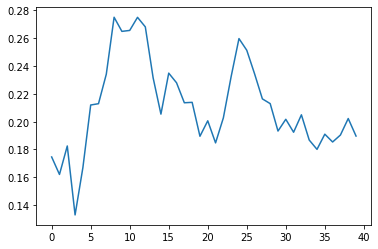

In [56]:
_jaccard = history.history['val_jaccard_index']
sns.lineplot(list(range(len(_jaccard))), _jaccard)

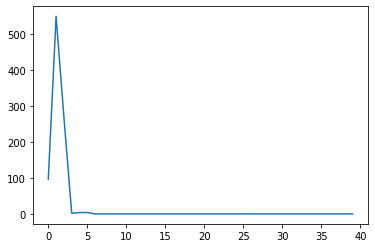

In [57]:
_loss = history.history['val_loss']
sns.lineplot(list(range(len(_loss))), _loss)

In [54]:
!cat "drive/My Drive/DCI-Net/time_logs.jsonl" | jq

{
  "datetimeUTC": "2019-10-28 20:46:23.879399",
  "function": "train_segnet",
  "args": [
    "<class 'tensorflow.python.keras.engine.training.Model'>",
    "drive/My Drive/DCI-Net/Colab_data/Dataset 1",
    "drive/My Drive/DCI-Net/Colab_data/Dataset 1"
  ],
  "kwargs": {
    "batch_size": 8,
    "epochs": 50,
    "steps_per_epoch": 100,
    "model_file": "drive/My Drive/DCI-Net/second_mutlires_gpu_WBC.h5"
  },
  "time": 7054.45720076561
}
{
  "datetimeUTC": "2019-10-29 02:26:33.794570",
  "function": "train_segnet",
  "args": [
    "<class 'tensorflow.python.keras.engine.training.Model'>",
    "drive/My Drive/DCI-Net/Colab_data/Dataset 1",
    "drive/My Drive/DCI-Net/Colab_data/Dataset 1"
  ],
  "kwargs": {
    "batch_size": 8,
    "epochs": 1,
    "steps_per_epoch": 10,
    "model_file": "drive/My Drive/DCI-Net/second_mutlires_gpu_WBC.h5"
  },
  "time": 90.98878622055054
}
{
  "datetimeUTC": "2019-10-29 02:37:01.130320",
  "function": "_dummy_debug_function",
  "args": [
    5,
    

In [0]:
# 1 validación 5 pliegues
def 

In [0]:
@timing.time_log(path_to_logfile=_log_file)
def _dummy_debug_function(*args, **kw):
  pass
  

In [0]:
log

NameError: ignored

In [0]:
_dummy_debug_function(5, '234', 5.2, hola='pass', foo='bar')